# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## 5.1 Consider the time series data shown in Chapter 4, Table E4.2.

In [3]:
import pandas as pd

# Data as dictionary
cpi_data = {
    'Month-Year': [
        'Jan-1995', 'Feb-1995', 'Mar-1995', 'Apr-1995', 'May-1995', 'Jun-1995', 'Jul-1995', 'Aug-1995', 'Sep-1995', 'Oct-1995', 'Nov-1995', 'Dec-1995',
        'Jan-1996', 'Feb-1996', 'Mar-1996', 'Apr-1996', 'May-1996', 'Jun-1996', 'Jul-1996', 'Aug-1996', 'Sep-1996', 'Oct-1996', 'Nov-1996', 'Dec-1996',
        'Jan-1997', 'Feb-1997', 'Mar-1997', 'Apr-1997', 'May-1997', 'Jun-1997', 'Jul-1997', 'Aug-1997', 'Sep-1997', 'Oct-1997', 'Nov-1997', 'Dec-1997',
        'Jan-1998', 'Feb-1998', 'Mar-1998', 'Apr-1998', 'May-1998', 'Jun-1998', 'Jul-1998', 'Aug-1998', 'Sep-1998', 'Oct-1998', 'Nov-1998', 'Dec-1998',
        'Jan-1999', 'Feb-1999', 'Mar-1999', 'Apr-1999', 'May-1999', 'Jun-1999', 'Jul-1999', 'Aug-1999', 'Sep-1999', 'Oct-1999', 'Nov-1999', 'Dec-1999',
        'Jan-2000', 'Feb-2000', 'Mar-2000', 'Apr-2000', 'May-2000', 'Jun-2000', 'Jul-2000', 'Aug-2000', 'Sep-2000', 'Oct-2000', 'Nov-2000', 'Dec-2000',
        'Jan-2001', 'Feb-2001', 'Mar-2001', 'Apr-2001', 'May-2001', 'Jun-2001', 'Jul-2001', 'Aug-2001', 'Sep-2001', 'Oct-2001', 'Nov-2001', 'Dec-2001',
        'Jan-2002', 'Feb-2002', 'Mar-2002', 'Apr-2002', 'May-2002', 'Jun-2002', 'Jul-2002', 'Aug-2002', 'Sep-2002', 'Oct-2002', 'Nov-2002', 'Dec-2002',
        'Jan-2003', 'Feb-2003', 'Mar-2003', 'Apr-2003', 'May-2003', 'Jun-2003', 'Jul-2003', 'Aug-2003', 'Sep-2003', 'Oct-2003', 'Nov-2003', 'Dec-2003',
        'Jan-2004', 'Feb-2004', 'Mar-2004', 'Apr-2004', 'May-2004', 'Jun-2004', 'Jul-2004', 'Aug-2004', 'Sep-2004', 'Oct-2004', 'Nov-2004', 'Dec-2004'
    ],
    'CPI': [
        150.3, 150.9, 151.4, 151.9, 152.2, 152.5, 152.5, 152.9, 153.2, 153.7, 153.6, 153.5,
        154.4, 154.9, 155.7, 156.3, 156.6, 156.7, 157.0, 157.3, 157.8, 158.3, 158.6, 158.6,
        159.1, 159.6, 160.0, 160.2, 160.1, 160.3, 160.5, 160.8, 161.2, 161.6, 161.5, 161.3,
        161.6, 161.9, 162.2, 162.5, 162.8, 163.0, 163.2, 163.4, 163.6, 164.0, 164.0, 163.9,
        164.3, 164.5, 165.0, 166.2, 166.2, 166.2, 166.7, 167.1, 167.9, 168.2, 168.3, 168.3,
        168.8, 169.8, 171.2, 171.3, 171.5, 172.4, 172.8, 172.8, 173.7, 174.0, 174.1, 174.0,
        175.1, 175.8, 176.2, 176.9, 177.7, 178.0, 177.5, 177.5, 178.3, 177.7, 177.4, 176.7,
        177.1, 177.8, 178.8, 179.8, 179.8, 179.9, 180.1, 180.7, 181.0, 181.3, 181.3, 180.9,
        181.7, 183.1, 184.2, 183.8, 183.5, 183.7, 183.9, 184.6, 185.2, 185.0, 184.5, 184.3,
        185.2, 186.2, 187.4, 188.0, 189.1, 189.7, 189.4, 189.5, 189.9, 190.9, 191.0, 190.3
    ]
}
# Create DataFrame
df_cpi = pd.DataFrame(cpi_data)

# Convert Month-Year to datetime
df_cpi['Date'] = pd.to_datetime(df_cpi['Month-Year'], format='%b-%Y')
df_cpi.set_index('Date', inplace=True)
df_cpi.drop(columns='Month-Year', inplace=True)

# Show result
df_cpi.head()

,CPI
Date,
1995-01-01,150.3
1995-02-01,150.9
1995-03-01,151.4
1995-04-01,151.9
1995-05-01,152.2


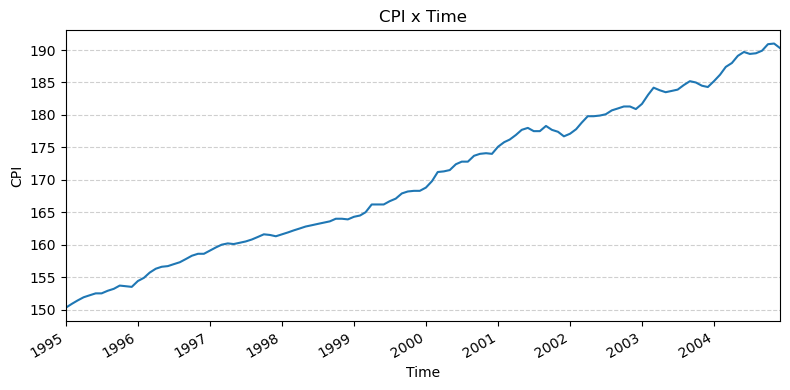

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df_cpi)
ax.set_xlabel('Time')
ax.set_ylabel('CPI')
ax.set_title('CPI x Time')
ax.set_xlim(pd.to_datetime('1995-01-01'), pd.to_datetime('2004-12-01'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

**a. Fit an appropriate ARIMA model to the first 40 observations of
this time series.**

In [5]:
# Load the CPI DataFrame
cpi_train = df_cpi.iloc[:40]   # First 40 observations
cpi_series = cpi_train['CPI']

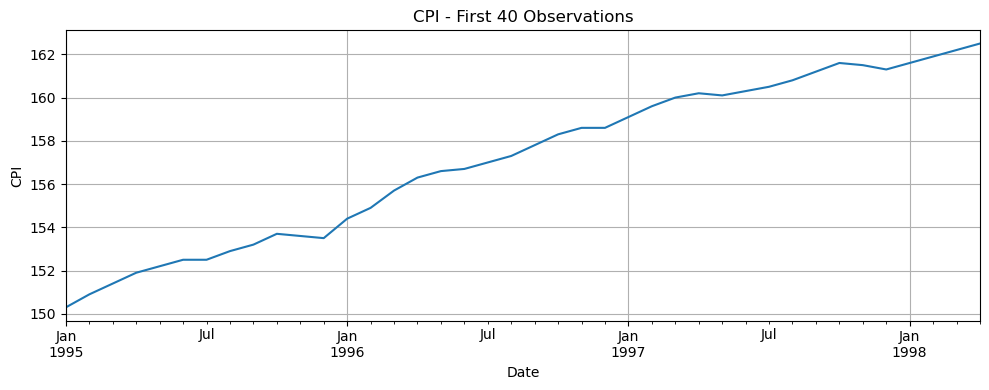

In [6]:
# Plot and check for stationarity visually
cpi_series.plot(title='CPI - First 40 Observations', figsize=(10, 4))
plt.ylabel('CPI')
plt.grid(True)
plt.tight_layout()
plt.show()

In [7]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(cpi_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.6663
p-value: 0.4486

p-value > alpha; H0: Not Stationary


In [8]:
# Difference the series if non-stationary
diff_series = cpi_series.diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -4.7497
p-value: 0.0001

p-value < alpha; Ha: Stationary


    d = 1

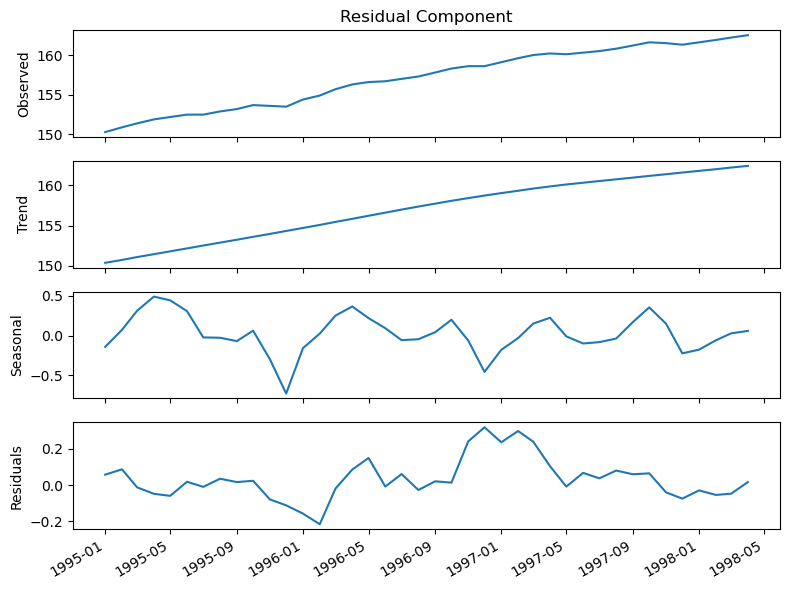

In [9]:
decomposition = STL(cpi_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax1.set_title("Trend Component")

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax1.set_title("Seasonal Component")

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax1.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

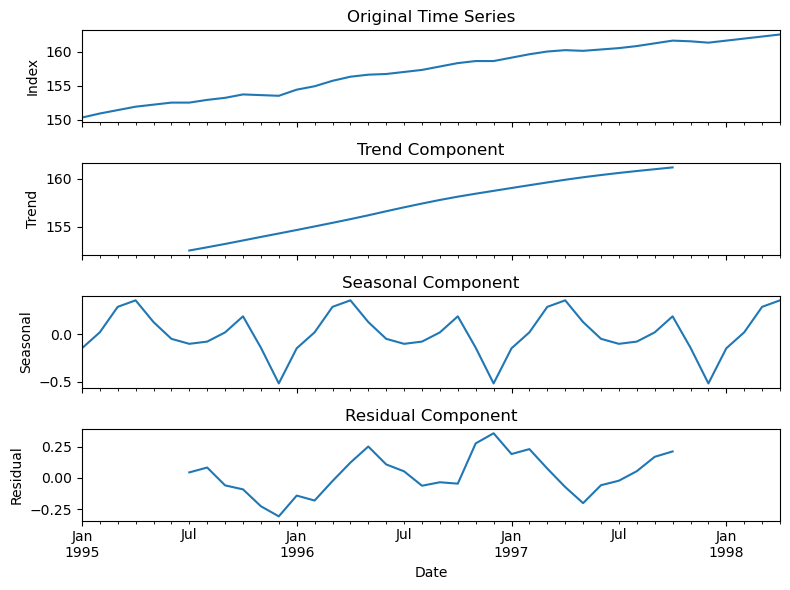

In [10]:
# Perform seasonal decomposition
nao_decom = seasonal_decompose(cpi_series, model='aditive') 

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

nao_decom.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Index')

nao_decom.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

nao_decom.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

nao_decom.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [11]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(nao_decom.seasonal.dropna())

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")


ADF Statistic: -124630148937297.34
      p-value: 0.0

p-value < alpha; Ha: Stationary


    D = 0

In [12]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2      # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(3))]*2        # Define search ranges for seasonal parameters (P, Q): each from 0 to 2

In [13]:
vals = combinator([P_ns, [1], Q_ns, P_s, [0], Q_s])
#vals

In [14]:
score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')

    m = SARIMAX(cpi_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, 12),  # 24 = data in hours; 12 = data in months
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }

Running model #0 using SARIMA(0,1,0)(0,0,0,12)
Running model #15 using SARIMA(0,1,1)(2,0,0,12)
Running model #30 using SARIMA(0,1,3)(1,0,0,12)
Running model #45 using SARIMA(1,1,1)(0,0,0,12)
Running model #60 using SARIMA(1,1,2)(2,0,0,12)
Running model #75 using SARIMA(2,1,0)(1,0,0,12)
Running model #90 using SARIMA(2,1,2)(0,0,0,12)
Running model #105 using SARIMA(2,1,3)(2,0,0,12)
Running model #120 using SARIMA(3,1,1)(1,0,0,12)
Running model #135 using SARIMA(3,1,3)(0,0,0,12)


In [15]:
def get_best_model(score, c='AIC'):
    
    initial_score = score[0][c]        # Initialize with the first model's score
    best_model = 0                     # Track the index of the best model
    for k, v in score.items():         # Iterate over the models
        if v[c] < initial_score:       # Check if the current model has a lower score
            initial_score = v[c]       # Update the lowest score
            best_model = k             # Update the best model index
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')  # Display best model
    
    return score[best_model]['model']  # Return the best model

best_model = get_best_model(score, 'AIC')

Best model: 33 with lowest AIC score: -14.7390760968818


In [16]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
rank = pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

rank.head()

,index,non-seasonal order,seasonal order,AIC,AICc,model
0,33,"(0, 1, 3)","(2, 0, 0)",-14.739076,-4.239076,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,49,"(1, 1, 1)","(1, 0, 1)",-14.53993,-11.382035,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,13,"(0, 1, 1)","(1, 0, 1)",-14.460788,-12.460788,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,31,"(0, 1, 3)","(1, 0, 1)",-13.617588,-8.367588,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,15,"(0, 1, 1)","(2, 0, 0)",-13.351798,-9.351798,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [17]:
# Fit SARIMA model with seasonal order
model = SARIMAX(cpi_series, 
                order=(1, 1, 1), 
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
# Fit the model
model_fit = model.fit()

# Display Summary
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                   40
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                  12.270
Date:                            Wed, 09 Apr 2025   AIC                            -14.540
Time:                                    08:19:26   BIC                             -8.446
Sample:                                01-01-1995   HQIC                           -12.850
                                     - 04-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5412      0.349      1.550      0.121      -0.143       1.226
ma.L1         -0.2340      0.386   

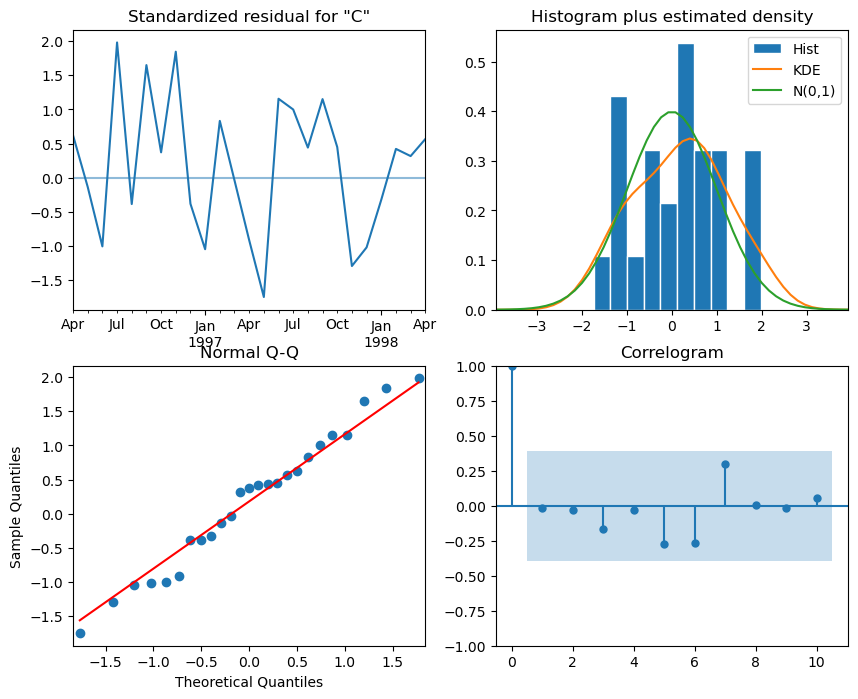

In [18]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit.plot_diagnostics(figsize=(10, 8))

In [19]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals1 = acorr_ljungbox(model_fit.resid , np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals1['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals1

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,2.841197,0.091876
2,2.841398,0.241545
3,2.841507,0.416713
4,2.841570,0.584679
5,2.841745,0.724368
6,2.841773,0.828428
7,2.842148,0.899211
8,2.842149,0.943869
9,2.842498,0.970213
10,2.842870,0.984884


In [20]:
import pmdarima as pm

auto_model = pm.auto_arima(cpi_series,            # Fit an automatic ARIMA model to the training data
                           seasonal=True,         # Enable seasonal ARIMA modeling
                           m=12,                  # Set the seasonal period (12 for monthly data with yearly seasonality)
                           test='adf',            # Use the Augmented Dickey-Fuller test to determine the order of differencing (d)
                           stepwise=True)         # Use a stepwise algorithm to efficiently search for the best model

print(auto_model.summary())                       # Display a statistical summary of the selected ARIMA model

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   40
Model:             SARIMAX(1, 1, 0)x(2, 0, 0, 12)   Log Likelihood                   6.611
Date:                            Wed, 09 Apr 2025   AIC                             -3.221
Time:                                    08:19:29   BIC                              5.096
Sample:                                01-01-1995   HQIC                            -0.237
                                     - 04-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0625      0.043      1.443      0.149      -0.022       0.147
ar.L1          0.3076      0.195   

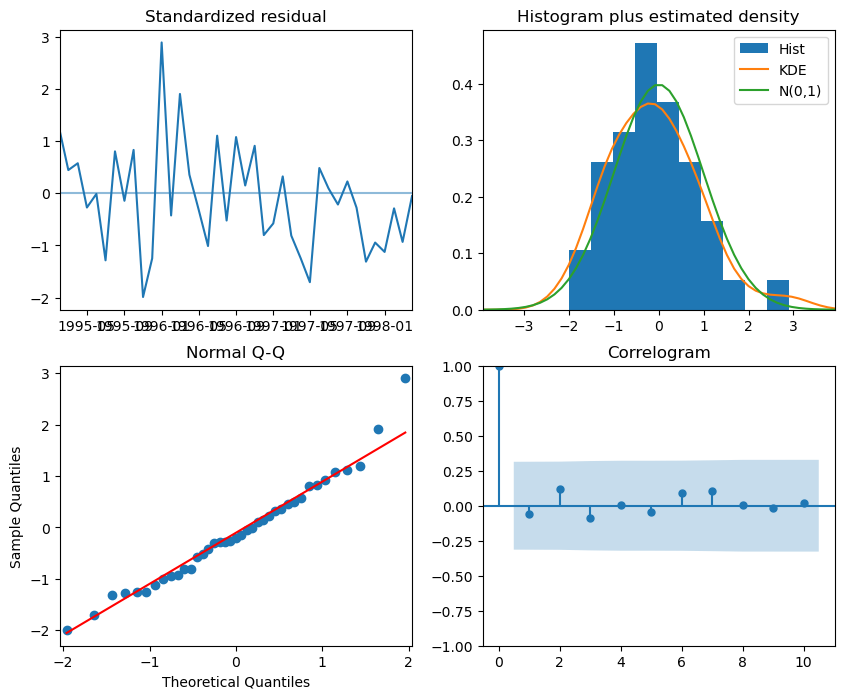

In [21]:
# Diagnostic plots for the model, including residuals and other model checks
auto_model.plot_diagnostics(figsize=(10, 8))  

In [22]:
auto_model = pm.auto_arima(cpi_series,            # Fit an automatic ARIMA model to the training data
                           seasonal=True,         # Enable seasonal ARIMA modeling
                           m=12,                  # Set seasonal period (12 months for yearly seasonality)
                           test='adf',            # Use Augmented Dickey-Fuller test to determine order of differencing (d)
                           stepwise=True,         # Use stepwise search to reduce computation time
                           trace=True)            # Print progress of model selection to the console

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2.803, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4.002, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-2.620, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=0.981, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=40.322, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3.487, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=-3.221, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-1.445, Time=0.32 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-3.079, Time=0.15 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=-1.651, Time=0.15 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=-1.571, Time=0.24 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=-1.441, Time=0.24 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-2.436, Time=0.12 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=0.254, Time=0.37 sec
 ARIMA(1,1,0)(2,0,0)[12]             : AIC=1.626, Ti

In [23]:
filtered_results = rank[rank['non-seasonal order'] == (1,1,0)]
filtered_results

,index,non-seasonal order,seasonal order,AIC,AICc,model
13,42,"(1, 1, 0)","(2, 0, 0)",-11.795495,-7.35105,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
16,40,"(1, 1, 0)","(1, 0, 1)",-11.706982,-9.80222,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
30,43,"(1, 1, 0)","(2, 0, 1)",-10.575168,-3.075168,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
48,44,"(1, 1, 0)","(2, 0, 2)",-9.118279,2.881721,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
56,39,"(1, 1, 0)","(1, 0, 0)",-8.435419,-7.34451,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
91,41,"(1, 1, 0)","(1, 0, 2)",-5.126238,2.373762,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
102,37,"(1, 1, 0)","(0, 0, 1)",-2.251882,-1.160973,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
111,38,"(1, 1, 0)","(0, 0, 2)",1.524151,5.968595,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
136,36,"(1, 1, 0)","(0, 0, 0)",12.802924,13.145781,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


**b. Make one-step-ahead forecasts of the last 10 observations. Determine the forecast errors.**

In [24]:
# Ensure the index is datetime if not already
df_cpi.index = pd.to_datetime(df_cpi.index)

# Excluir os últimos 10 pontos para treino
train = df_cpi.iloc[:-10]
test = df_cpi.iloc[-10:]

In [25]:
# Fit SARIMA model on training data
model = SARIMAX(train['CPI'],
                order=(1, 1, 1),
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit = model.fit()

# Forecast the next 10 time points (one-step-ahead)
forecast = model_fit.get_forecast(steps=10)

# Extract predicted mean
forecast_mean = forecast.predicted_mean

# Compare with actuals
forecast_df = pd.DataFrame({
    'Actual': test['CPI'],
    'Forecast': forecast_mean,
})

# Calculate forecast error
forecast_df['Error'] = forecast_df['Actual'] - forecast_df['Forecast']

# Show the results
forecast_df

,Actual,Forecast,Error
2004-03-01,187.4,187.067664,0.332336
2004-04-01,188.0,187.472255,0.527745
2004-05-01,189.1,187.602436,1.497564
2004-06-01,189.7,187.864416,1.835584
2004-07-01,189.4,188.016851,1.383149
2004-08-01,189.5,188.397603,1.102397
2004-09-01,189.9,188.974128,0.925872
2004-10-01,190.9,189.080536,1.819464
2004-11-01,191.0,188.952647,2.047353
2004-12-01,190.3,188.696519,1.603481


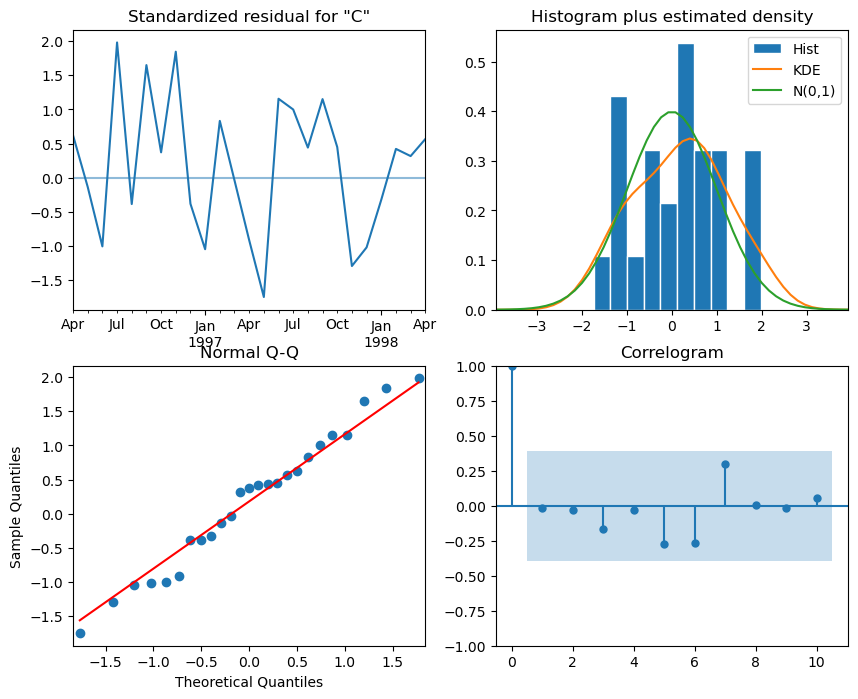

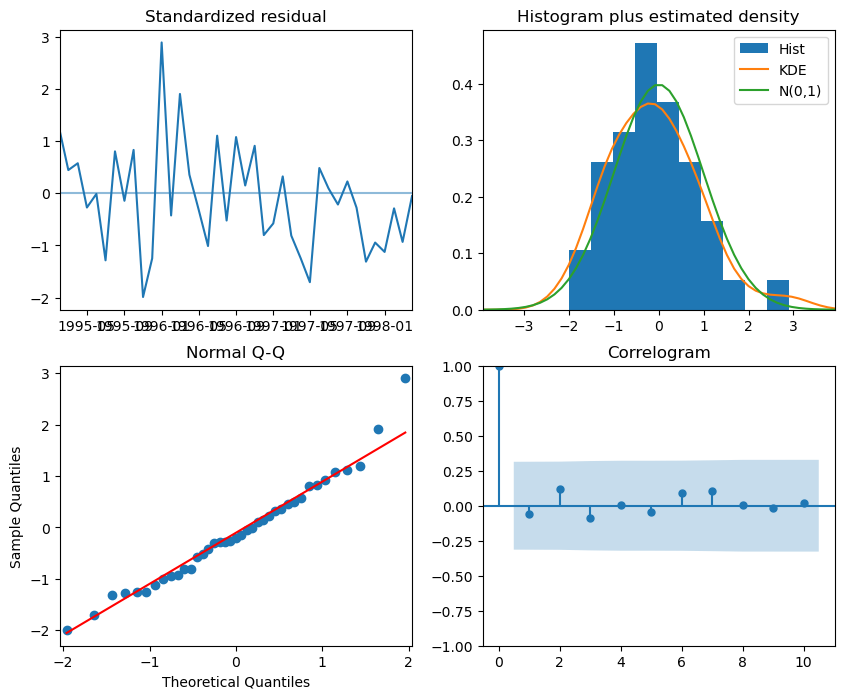

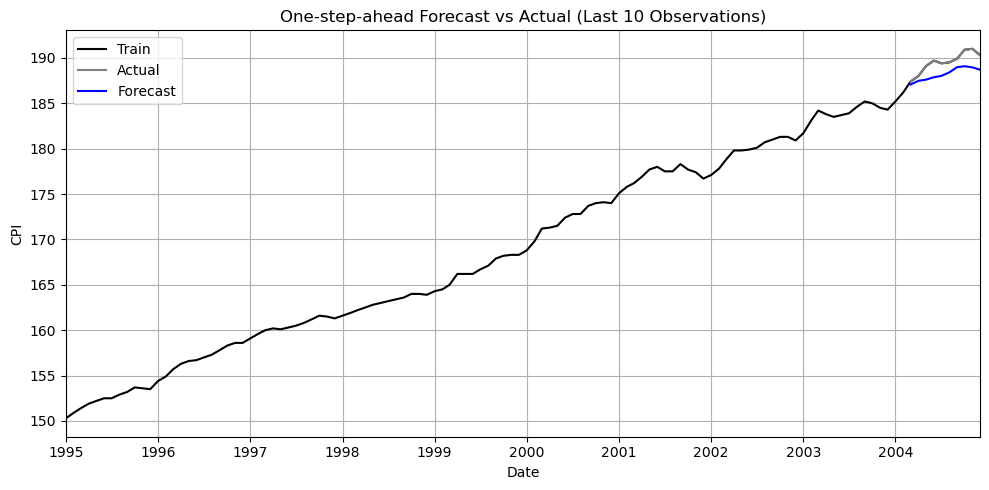

In [26]:
# Plot actual and forecast values
plt.figure(figsize=(10, 5))
plt.plot(df_cpi.index, df_cpi, label='Train', color='black')                          # Actual values
plt.plot(forecast_df.index, forecast_df['Actual'], label='Actual', color='gray')      # Actual values
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')  # Forecasted values
plt.title('One-step-ahead Forecast vs Actual (Last 10 Observations)')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.xlim(pd.to_datetime(['1995-01-01', '2004-12-01']))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show();

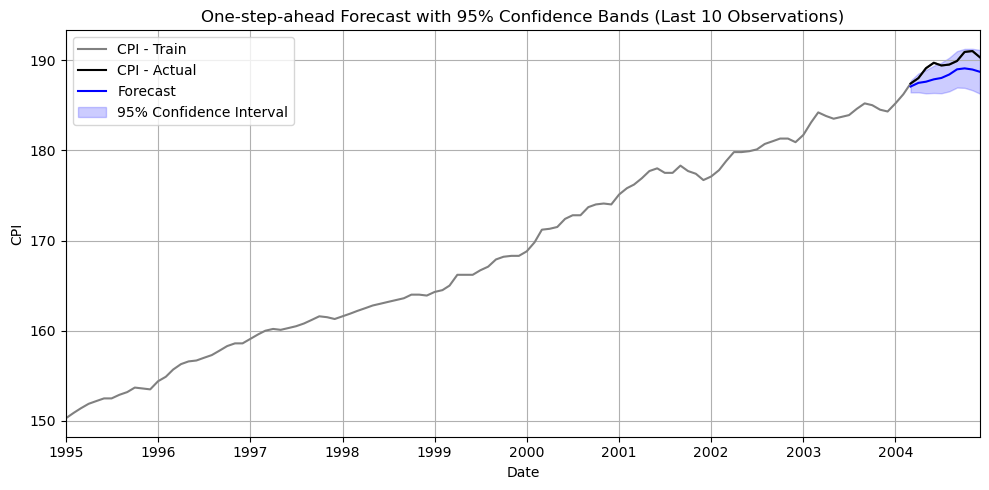

In [27]:
# Generate forecast and confidence intervals
forecast = model_fit.get_forecast(steps=10)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()  # 95% confidence interval

# Create DataFrame to compare forecast and actuals
forecast_df = pd.DataFrame({
    'Actual': test['CPI'],
    'Forecast': forecast_mean
})
forecast_df['Error'] = forecast_df['Actual'] - forecast_df['Forecast']

# Plot actual values, forecasts, and confidence bands
plt.figure(figsize=(10, 5))
plt.plot(df_cpi.index, df_cpi, label='CPI - Train', color='gray')                       # Full CPI series
plt.plot(forecast_df.index, forecast_df['Actual'], label='CPI - Actual', color='black') # Actual CPI in test set
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='blue')    # Forecasted CPI

# Add 95% confidence bands
plt.fill_between(conf_int.index,
                 conf_int.iloc[:, 0],   # Lower bound
                 conf_int.iloc[:, 1],   # Upper bound
                 color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('One-step-ahead Forecast with 95% Confidence Bands (Last 10 Observations)')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.xlim(pd.to_datetime(['1995-01-01', '2004-12-01']))  # Set x-axis date range
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## 5.2 Consider the time series data shown in Table E5.1.

In [28]:
# Flatten the list of values
yt_values = [
    29, 20, 25, 29, 31, 33, 34, 27, 26, 30,
    29, 28, 28, 26, 27, 26, 30, 28, 26, 30,
    31, 30, 37, 30, 33, 31, 27, 33, 37, 29,
    28, 30, 29, 34, 30, 20, 17, 23, 24, 34,
    36, 35, 33, 29, 25, 27, 30, 29, 28, 32
]

# Create the DataFrame
df = pd.DataFrame({
    'Period': range(1, 51),
    'y_t': yt_values
})

# Display the first few rows
df.head()

,Period,y_t
0,1,29
1,2,20
2,3,25
3,4,29
4,5,31


**a. Make a time series plot of the data.**

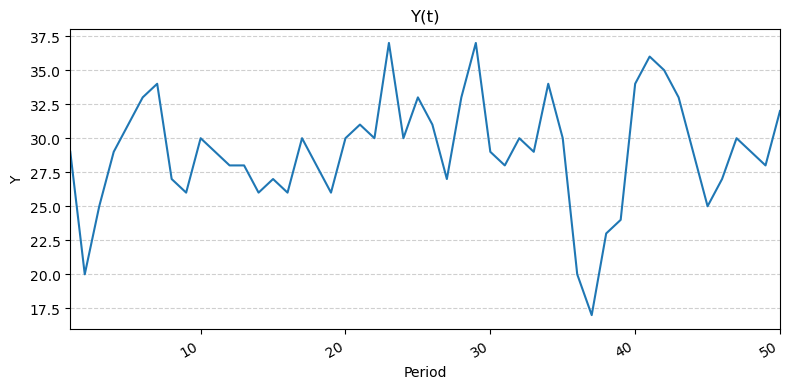

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df['Period'], df['y_t'])
ax.set_xlabel('Period')
ax.set_ylabel('Y')
ax.set_title('Y(t)')
ax.set_xlim(1, 50)
ax.grid(axis='y', linestyle='--', alpha=0.6)  

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

**b. Calculate and plot the sample autocorrelation and PACF. Is there
significant autocorrelation in this time series?**

In [30]:
y_series = df['y_t']

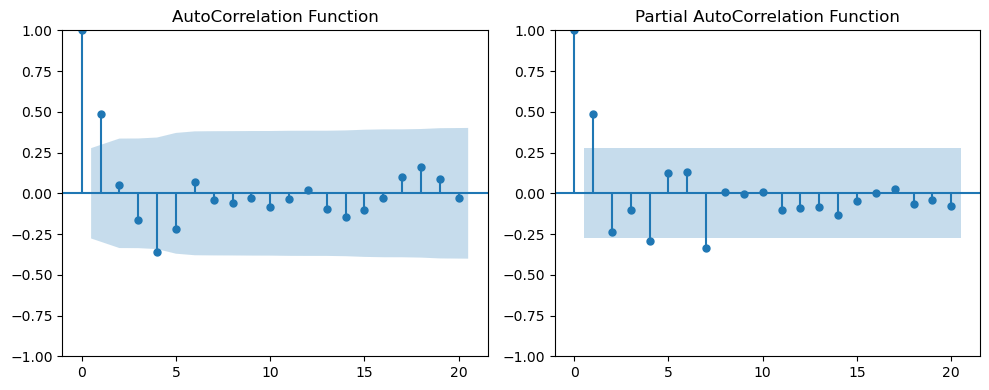

In [31]:
# Create a 1x2 grid for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

# Interest Rate Data
plot_acf(y_series, ax=axes[0], lags=20)
axes[0].set_title("AutoCorrelation Function", fontsize=12)

# Simulated Random Walk Data
plot_pacf(y_series, ax=axes[1], lags=20)
axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)

plt.tight_layout()
plt.show();

**c. Identify and fit an appropriate ARIMAmodel to these data. Check
for model adequacy.**

In [32]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df[['y_t']])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -3.1424
p-value: 0.0236

p-value < alpha; Ha: Stationary


    d = 0

In [33]:
# Convert y_t column into a standalone Series
y_series = df['y_t']

type(y_series)

pandas.core.series.Series

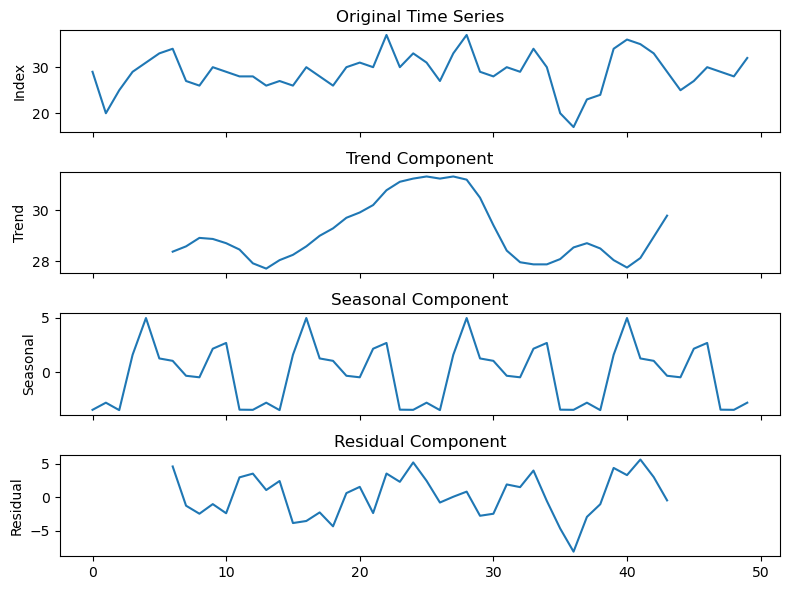

In [34]:
# Perform seasonal decomposition
decom = seasonal_decompose(y_series, model="aditive", period=12)

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

decom.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Index')

decom.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

decom.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

decom.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

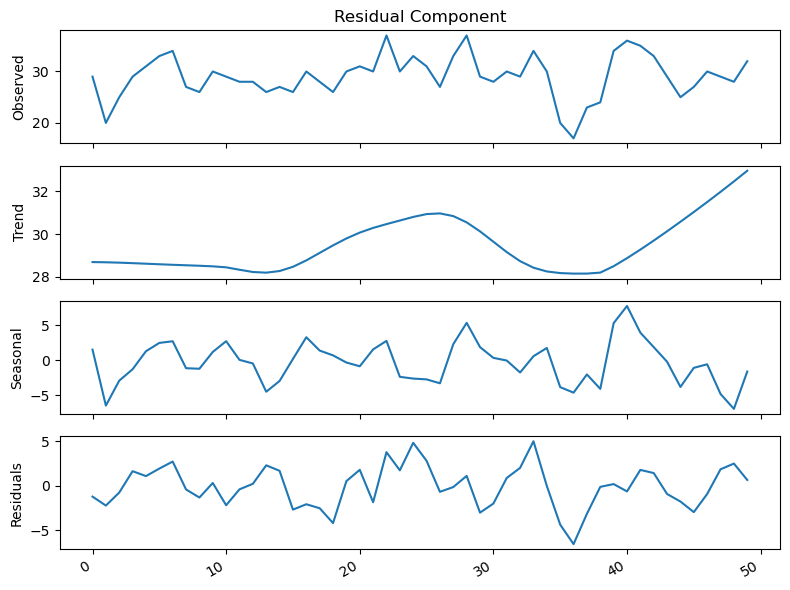

In [35]:
decomposition = STL(y_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')
ax1.set_title("Trend Component")

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')
ax1.set_title("Seasonal Component")

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')
ax1.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [36]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(decom.seasonal.dropna())

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")


ADF Statistic: -1755582793283523.2
      p-value: 0.0

p-value < alpha; Ha: Stationary


    D = 0

In [37]:
auto_model = pm.auto_arima(y_series,              # Fit an automatic ARIMA model to the training data
                           seasonal=True,         # Enable seasonal ARIMA modeling
                           m=12,                  # Set seasonal period (12 months for yearly seasonality)
                           test='adf',            # Use Augmented Dickey-Fuller test to determine order of differencing (d)
                           stepwise=True,         # Use stepwise search to reduce computation time
                           trace=True)            # Print progress of model selection to the console

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=276.653, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=286.773, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=279.254, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=274.505, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=481.811, Time=0.00 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=272.638, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=274.509, Time=0.13 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=276.483, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=274.296, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=274.291, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=275.534, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=276.289, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[12]             : AIC=425.126, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[12] intercept
Total fit time: 0.901 seconds


In [38]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    y_series,                   # Time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months in a year (seasonal period)
    d=0,                        # Set differencing 
    D=0,                        # Set seasonal differencing
    start_p=0, max_p=2,         # p from 0 to 2
    start_q=0, max_q=2,         # q from 0 to 2
    start_P=0, max_P=2,         # P from 0 to 2
    start_Q=0, max_Q=2,         # Q from 0 to 2
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

# Show the best model summary
#print(auto_model.summary())

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=286.773, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=288.755, Time=0.01 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=290.659, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=288.753, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=290.757, Time=0.07 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=291.464, Time=0.22 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=290.642, Time=0.20 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=292.702, Time=0.22 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=272.638, Time=0.01 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=274.505, Time=0.02 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=276.475, Time=0.05 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=274.509, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=276.483, Time=0.10 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=278.474, Time=0.11 sec
 ARIMA(0,0,1)(

    Based on our ACF and PACF graphs, this is not a good model.

In [39]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, D_ns, Q_ns = [list(range(3))]*3          # Define search ranges for non-seasonal parameters (p, d, q): each from 0 to 2
P_s, D_s, Q_s = [list(range(3))]*3             # Define search ranges for seasonal parameters (P, D, Q): each from 0 to 2

vals = combinator([P_ns, [0], Q_ns, P_s, [0], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')

    m = SARIMAX(y_series,                      # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, 12),  # 24 = seasonal period (data in hours)
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(2,0,0,12)
Running model #30 using SARIMA(1,0,0)(1,0,0,12)
Running model #45 using SARIMA(1,0,2)(0,0,0,12)
Running model #60 using SARIMA(2,0,0)(2,0,0,12)
Running model #75 using SARIMA(2,0,2)(1,0,0,12)


In [40]:
# Convert the score dictionary to a DataFrame, transpose it, sort by AIC (ascending), and reset the index
rank = pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 

rank.head()

,index,non-seasonal order,seasonal order,AIC,AICc,model
0,53,"(1, 0, 2)","(2, 0, 2)",138.025163,148.310877,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,47,"(1, 0, 2)","(0, 0, 2)",139.588701,144.838701,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,74,"(2, 0, 2)","(0, 0, 2)",140.040437,147.507104,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,50,"(1, 0, 2)","(1, 0, 2)",140.702353,148.16902,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,80,"(2, 0, 2)","(2, 0, 2)",141.072519,154.918673,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


#### PMDArima model

In [41]:
# Fit SARIMA model with seasonal order
model1 = SARIMAX(cpi_series, 
                order=(0, 0, 1), 
                seasonal_order=(0, 0, 0, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
# Fit the model
model_fit1 = model1.fit()

# Display Summary
print(model_fit1.summary())

                               SARIMAX Results                                
Dep. Variable:                    CPI   No. Observations:                   40
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -222.139
Date:                Wed, 09 Apr 2025   AIC                            448.278
Time:                        08:20:00   BIC                            451.553
Sample:                    01-01-1995   HQIC                           449.443
                         - 04-01-1998                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0000   2954.272      0.000      1.000   -5789.267    5791.267
sigma2      6361.3886   1.88e+07      0.000      1.000   -3.68e+07    3.68e+07
Ljung-Box (L1) (Q):                  14.11   Jarque-

#### Manual Model

In [42]:
# Fit SARIMA model with seasonal order
model2 = SARIMAX(cpi_series, 
                order=(1, 0, 2), 
                seasonal_order=(2, 0, 2, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)
# Fit the model
model_fit2 = model2.fit()

# Display Summary
print(model_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                CPI   No. Observations:                   40
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 12)   Log Likelihood                   9.167
Date:                            Wed, 09 Apr 2025   AIC                             -2.334
Time:                                    08:20:00   BIC                              2.186
Sample:                                01-01-1995   HQIC                            -3.263
                                     - 04-01-1998                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.002    446.333      0.000       0.996       1.004
ma.L1          0.3773      0.863   

#### PMDArima Model

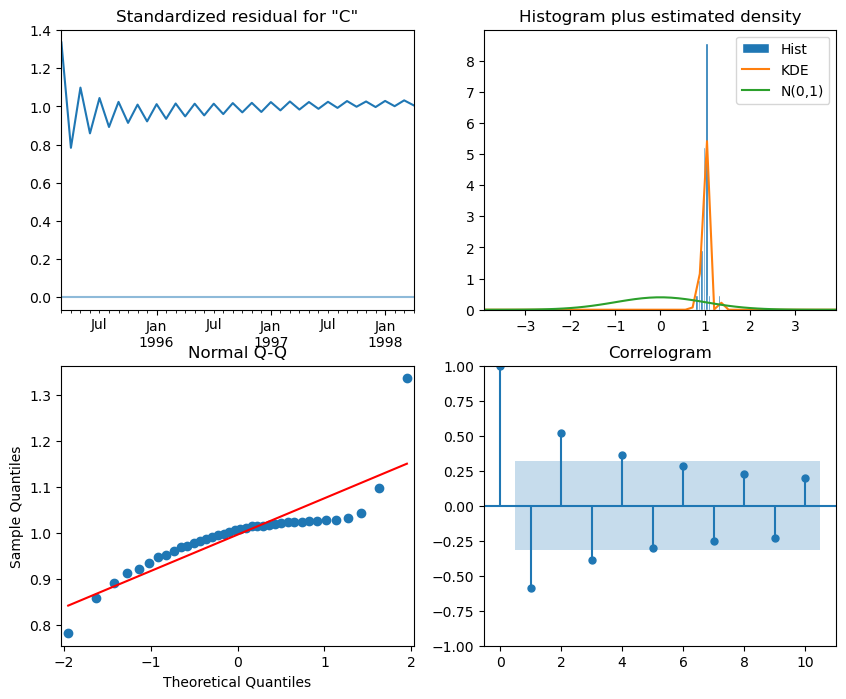

In [43]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit1.plot_diagnostics(figsize=(10, 8))

#### Manual Model

In [44]:
# Fit SARIMA model on training data
model2 = SARIMAX(y_series,
                order=(1, 0, 2),
                seasonal_order=(2, 0, 2, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit2 = model2.fit()

# Get the in-sample predicted values
fitted_values = model_fit2.fittedvalues        # In-sample predictions

# Compute residuals: actual - fitted
residuals = y_series - fitted_values           # Errors

# Combine into a DataFrame
df = pd.DataFrame({
    'Actual': y_series,
    'Fitted': fitted_values,
    'Residual': residuals
})

# Show the results
df

,Actual,Fitted,Residual
0,29,0.000000,29.000000
1,20,29.053837,-9.053837
2,25,20.037127,4.962873
3,29,25.046475,3.953525
4,31,29.053802,1.946198
5,33,31.057522,1.942478
6,34,33.061249,0.938751
7,27,34.063106,-7.063106
8,26,27.050117,-1.050117
9,30,26.048317,3.951683


In [45]:
# Fit SARIMA model on training data
model1 = SARIMAX(y_series,
                order=(0, 0, 1),
                seasonal_order=(0, 0, 0, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

model_fit1 = model1.fit()

# Get the in-sample predicted values
fitted_values1 = model_fit1.fittedvalues           # MODEL 1: PMDArima

# Compute residuals: actual - fitted
residuals1 = y_series - fitted_values1            # Errors

# Combine into a DataFrame
df['PMDArima'] = residuals1

# Show the results
df

,Actual,Fitted,Residual,PMDArima
0,29,0.000000,29.000000,29.000000
1,20,29.053837,-9.053837,20.000000
2,25,20.037127,4.962873,24.995137
3,29,25.046475,3.953525,16.500912
4,31,29.053802,1.946198,19.998946
5,33,31.057522,1.942478,18.000486
6,34,33.061249,0.938751,19.599436
7,27,34.063106,-7.063106,10.667004
8,26,27.050117,-1.050117,16.856800
9,30,26.048317,3.951683,15.250236


In [46]:
# Drop first row
df = df.iloc[1:].copy() 

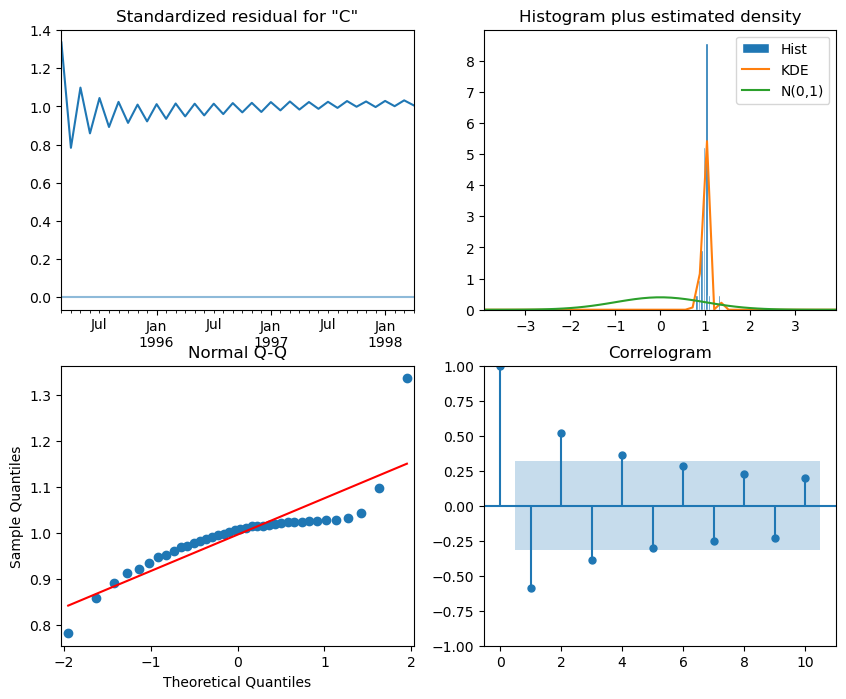

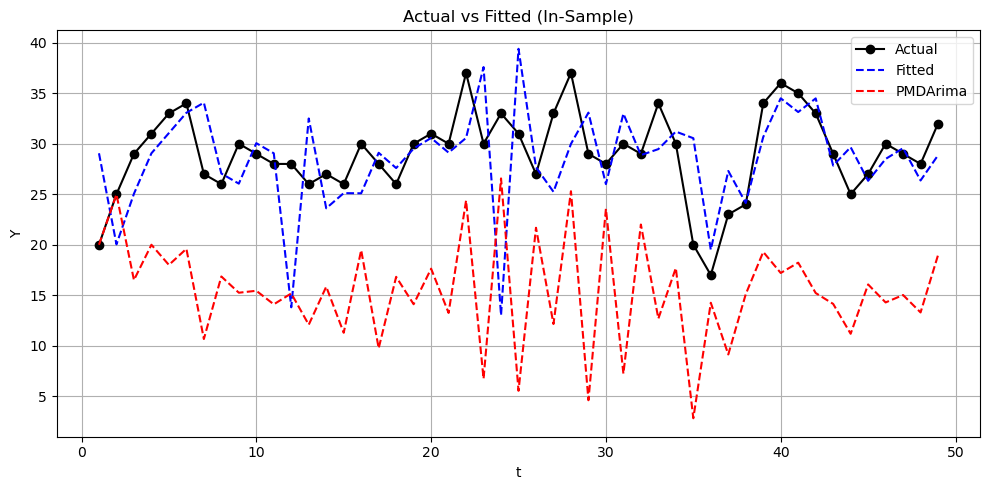

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(df['Actual'], label='Actual', color='black', marker='o')
plt.plot(df['Fitted'], label='Fitted', color='blue', linestyle='--')
plt.plot(df['PMDArima'], label='PMDArima', color='red', linestyle='--')
plt.title('Actual vs Fitted (In-Sample)')
plt.xlabel('t')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show();

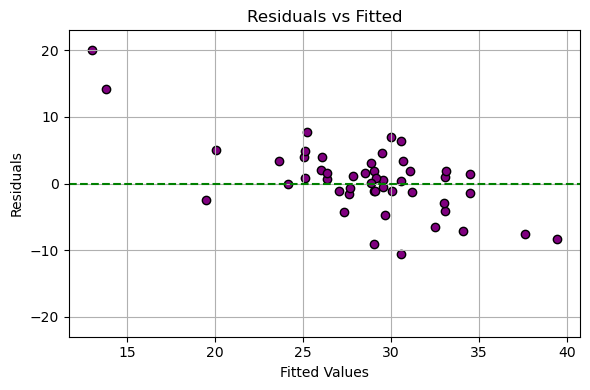

In [48]:
plt.figure(figsize=(6, 4))
plt.scatter(df['Fitted'], df['Residual'], color='purple', edgecolor='k')
plt.axhline(y=0, color='green', linestyle='--')          
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.ylim(-23,23)
plt.grid(True)
plt.tight_layout()
plt.show()

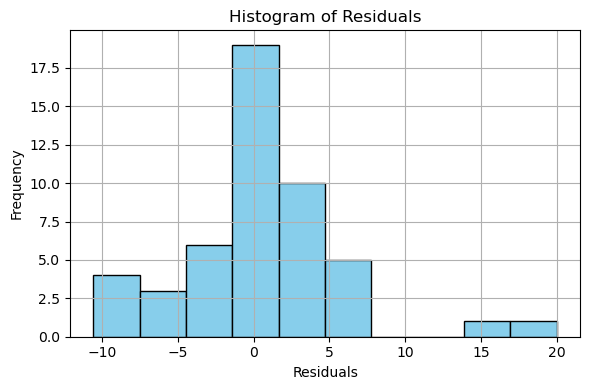

In [49]:
plt.figure(figsize=(6, 4))
plt.hist(df['Residual'], bins=10, edgecolor='black', color='skyblue')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show();

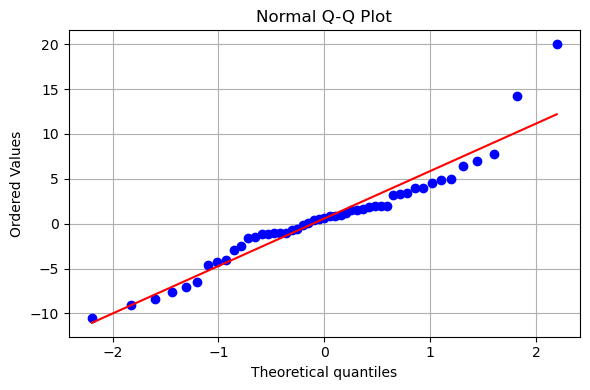

In [50]:
plt.figure(figsize=(6, 4))
stats.probplot(df['Residual'], dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

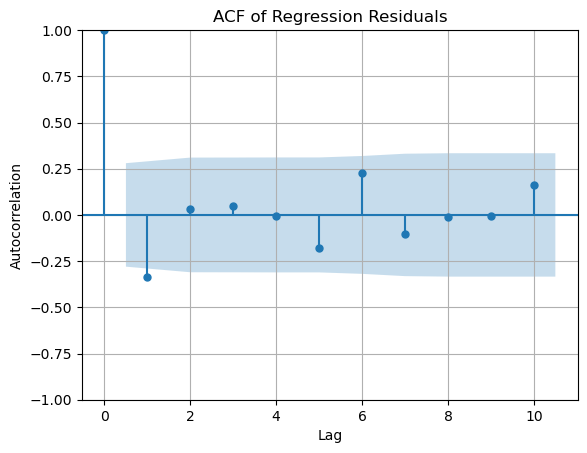

In [51]:
plot_acf(df['Residual'], lags=10)                    
plt.title('ACF of Regression Residuals')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

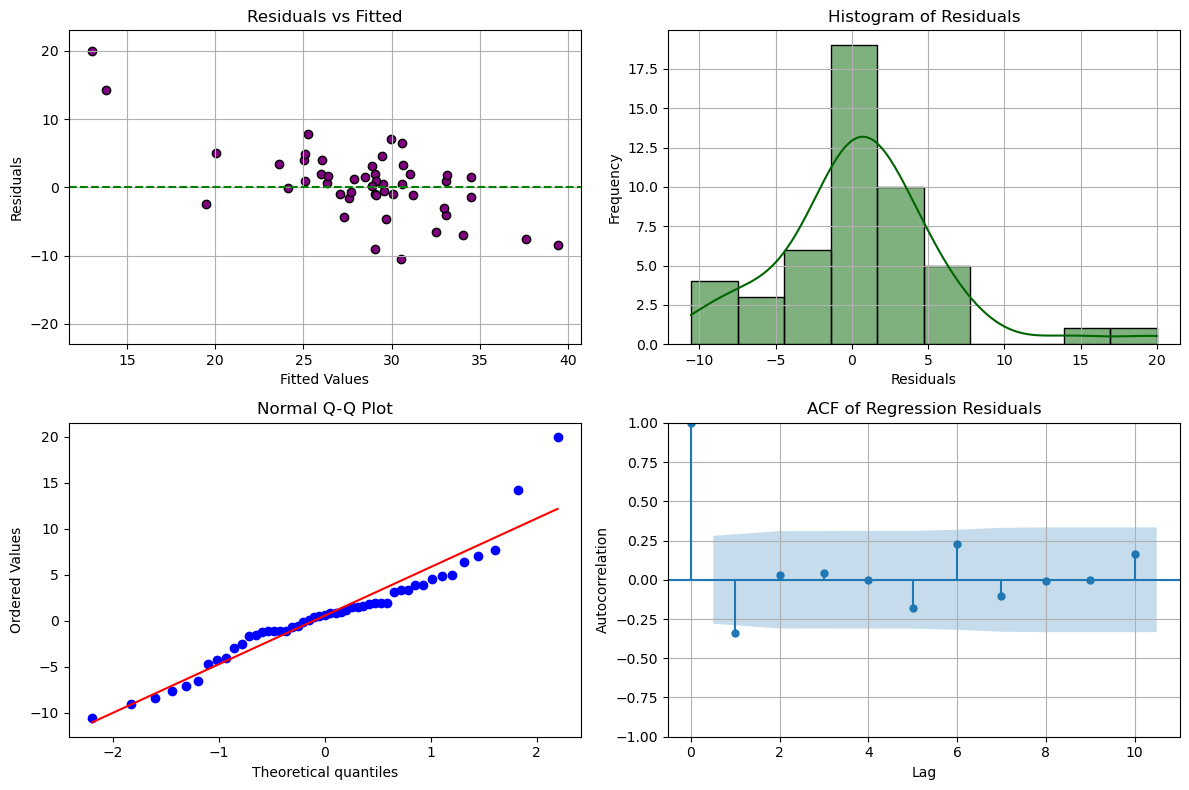

In [52]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# 1. Standardized Residuals
axes[0, 0].scatter(df['Fitted'], df['Residual'], color='purple', edgecolor='k')
axes[0, 0].axhline(y=0, color='green', linestyle='--')          
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted')
axes[0, 0].relim()
axes[0, 0].autoscale_view()
axes[0, 0].set_ylim(-23,23)
axes[0, 0].grid(True)

# 2. Histogram of Residuals
sns.histplot(df['Residual'], bins=10, edgecolor='black', color='darkgreen', kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Histogram of Residuals')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True)

# 3. Q-Q Plot
stats.probplot(df['Residual'], dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Normal Q-Q Plot')
plt.grid(True)

# 4. Correlogram (ACF)
plot_acf(df['Residual'], lags=10, ax=axes[1, 1])                    
axes[1, 1].set_title('ACF of Regression Residuals')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show();

In [53]:
# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(df['Residual'], np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

There are p-values < 0.05; Ha: Residuals are autocorrelated.



,lb_stat,lb_pvalue
1,5.936362,0.014832
2,5.985432,0.050151
3,6.098289,0.106925
4,6.099023,0.191874
5,7.902218,0.161708
6,10.866142,0.092603
7,11.521820,0.117422
8,11.526756,0.173600
9,11.527485,0.241276
10,13.262388,0.209369
